# Import Packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Make Water Vapor Profile Using GCM output

In [38]:
#  Load CESM model output as input for our model
cesm_data_path = "/data/keeling/a/mailes2/a/CESM_DATA/aqua_75perturb/outputdata/atm/hist/"
cesm_input = xr.open_dataset(cesm_data_path + "aqua_75perturb.cam.h0.0005-12.nc")
cesm_input

<xarray.Dataset>
Dimensions:        (lev: 30, ilev: 31, time: 1, lat: 96, lon: 144, slat: 95,
                    slon: 144, nbnd: 2)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 0006-01-01 00:00:00
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables: (12/163)
    hyam           (lev) float64 ...
    hybm           (lev) float64 ...
    hyai           (ilev) float64 ...
    hybi           (ilev) float64 ...
    P0             float64 ...
    date           (time) int32 ...
    ...             ...
    pom_a1_SRF     (time, lat, lon) float32 ...
    so4_a1_SRF     (time, lat, lon) float32 ...
    so4_a2_SRF     (time, lat, lon) float32 ...
    so4_a3_SRF     (time, lat, lon) float32 ...
    soa_a1_SRF     (time, lat, lon) float32 ...
    soa_a2_SRF     (time, lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             aqua_75perturb
    title:            UNSET
    logname:          mailes2
    host:             keeling-j31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...
    topography_file:  /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...

This is typical GCM output. The coordinates include elevation, time, latitude, longitude, and staggered lat + lon.

In [39]:
#  The specific humidity is stored in the variable called Q in this dataset:
cesm_input.Q

<xarray.DataArray 'Q' (time: 1, lev: 30, lat: 96, lon: 144)>
[414720 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0006-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

This is specific humidity.

In [40]:
cesm_input.gw

<xarray.DataArray 'gw' (lat: 96)>
array([0.000137, 0.001093, 0.002185, 0.003275, 0.004361, 0.005443, 0.006518,
       0.007587, 0.008647, 0.009697, 0.010737, 0.011765, 0.012781, 0.013782,
       0.014768, 0.015739, 0.016692, 0.017626, 0.018542, 0.019437, 0.020311,
       0.021162, 0.021991, 0.022795, 0.023575, 0.024329, 0.025056, 0.025756,
       0.026427, 0.02707 , 0.027683, 0.028266, 0.028818, 0.029339, 0.029827,
       0.030283, 0.030705, 0.031094, 0.031449, 0.03177 , 0.032056, 0.032307,
       0.032522, 0.032702, 0.032847, 0.032955, 0.033027, 0.033063, 0.033063,
       0.033027, 0.032955, 0.032847, 0.032702, 0.032522, 0.032307, 0.032056,
       0.03177 , 0.031449, 0.031094, 0.030705, 0.030283, 0.029827, 0.029339,
       0.028818, 0.028266, 0.027683, 0.02707 , 0.026427, 0.025756, 0.025056,
       0.024329, 0.023575, 0.022795, 0.021991, 0.021162, 0.020311, 0.019437,
       0.018542, 0.017626, 0.016692, 0.015739, 0.014768, 0.013782, 0.012781,
       0.011765, 0.010737, 0.009697, 0.008647, 0.007587, 0.006518, 0.005443,
       0.004361, 0.003275, 0.002185, 0.001093, 0.000137])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    long_name:  gauss weights

Here's the Gaussian weights, which we'll use to weight the humidity by latitudinal area.

In [42]:
# Take the global, annual average of the specific humidity
weight_factor = cesm_input.gw / cesm_input.gw.mean(dim='lat')
Qglobal = (cesm_input.Q * weight_factor).mean(dim=('lat','lon','time'))

Qglobal

<xarray.DataArray (lev: 30)>
array([1.78278975e-06, 1.79460139e-06, 1.79827627e-06, 1.79207183e-06,
       1.76551601e-06, 1.71390476e-06, 1.70135573e-06, 1.75774571e-06,
       1.86867065e-06, 2.22524300e-06, 3.53456248e-06, 7.74770191e-06,
       1.88927947e-05, 4.20126518e-05, 8.36031991e-05, 1.49990885e-04,
       2.69075152e-04, 5.18387560e-04, 9.42503312e-04, 1.41178462e-03,
       2.09427578e-03, 3.09788057e-03, 4.61196509e-03, 5.62421562e-03,
       6.25215972e-03, 6.78611418e-03, 7.22836529e-03, 7.50729269e-03,
       7.71502505e-03, 7.84586655e-03])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6

Here's the global averaged specific humidity. Its only dimension is in the vertical.

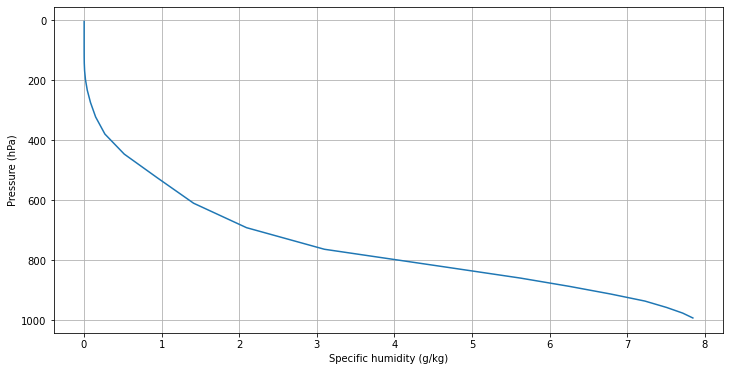

In [43]:
plt.rcParams["figure.figsize"] = (12,6)

#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air

plt.plot(Qglobal*1000., Qglobal.lev)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Specific humidity (g/kg)')
plt.grid()
plt.show()

# Create Single Model 

Let's look at how to create a model in climlab to run through RRTMG! We'll need to initiate a column_state, which is a variable dictionary of atmospheric temperatures ('Tatm') and surface mixed layer temperature ('Ts').

In [10]:
help(climlab.column_state)

Help on function column_state in module climlab.domain.initial:

column_state(num_lev=30, num_lat=1, lev=None, lat=None, water_depth=1.0)
    Sets up a state variable dictionary consisting of temperatures
    for atmospheric column (``Tatm``) and surface mixed layer (``Ts``).
    
    Surface temperature is always 288 K. Atmospheric temperature is initialized
    between 278 K at lowest altitude and 200 at top of atmosphere according to
    the number of levels given.
    
    **Function-call arguments** 
    
    
    :param int num_lev:         number of pressure levels
                                (evenly spaced from surface to top of atmosphere)
                                [default: 30]
    :param int num_lat:         number of latitude points on the axis
                                [default: 1]
    :param lev:                 specification for height axis (optional)
    :type lev:                  :class:`~climlab.domain.axis.Axis`
                                or pre

In [46]:
mystate = climlab.column_state(lev=Qglobal.lev, # These are the elevation levels. We'll be using CESM's elev. levels.
                               water_depth=2.5 
                              )
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.68965517, 205.37931034, 208.06896552,
       210.75862069, 213.44827586, 216.13793103, 218.82758621,
       221.51724138, 224.20689655, 226.89655172, 229.5862069 ,
       232.27586207, 234.96551724, 237.65517241, 240.34482759,
       243.03448276, 245.72413793, 248.4137931 , 251.10344828,
       253.79310345, 256.48275862, 259.17241379, 261.86206897,
       264.55172414, 267.24137931, 269.93103448, 272.62068966,
       275.31034483, 278.        ])})

We're ready to set up the RRTMG model now!

In [50]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',             # Model name
                              state=mystate,                                 # Initial temperature conditions
                              specific_humidity=Qglobal.values,              # Water vapor - coming from the CESM output
                              albedo = 0.25,                                 # Surface shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # Set the timestep to one day (measured in seconds)
                             )
radmodel

## Check Model State 
https://brian-rose.github.io/ClimateLaboratoryBook/courseware/radeq.html#the-observed-annual-global-mean-temperature-profile

In [15]:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [51]:
#  Here are the pressure levels in hPa


radmodel.lev

array([  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
        38.26829977,  54.59547974,  72.01245055,  87.82123029,
       103.31712663, 121.54724076, 142.99403876, 168.22507977,
       197.9080867 , 232.82861896, 273.91081676, 322.24190235,
       379.10090387, 445.9925741 , 524.68717471, 609.77869481,
       691.38943031, 763.40448111, 820.85836865, 859.53476653,
       887.02024892, 912.64454694, 936.19839847, 957.48547954,
       976.32540739, 992.55609512])

In [53]:
# Holds the volume mixing ratio of all the radiatively active gases in the column


radmodel.absorber_vmr # Most are just a single number because they are assumed to be well mixed in the atmosphere. [ppm]

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.58986625e-06, 8.52410351e-06, 7.78919969e-06, 5.46476836e-06,
        3.34368285e-06, 1.93461822e-06, 1.07096159e-06, 6.94499627e-07,
        5.01831109e-07, 3.65572055e-07, 2.69158425e-07, 2.03583137e-07,
        1.54787998e-07, 1.10860788e-07, 7.76051562e-08, 6.04133693e-08,
        5.22071836e-08, 4.63022306e-08, 4.18318657e-08, 3.88536279e-08,
        3.58544249e-08, 3.24419102e-08, 2.95116279e-08, 2.76335134e-08,
        2.64909935e-08, 2.54258396e-08, 2.44467502e-08, 2.35618862e-08,
        2.28285657e-08, 2.22005073e-08])}

# Input Parameters for RRTMG 
https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html

In [55]:
radmodel.compute_diagnostics()

In [59]:
radmodel.LW_flux_net

Field([240.51063454, 239.50346489, 238.96145768, 238.16285433,
       237.23865901, 236.26516081, 235.31694594, 234.45081869,
       233.63478819, 232.7001376 , 231.45431183, 229.56671302,
       226.13650515, 220.24947708, 211.66780285, 201.1502685 ,
       189.99760751, 177.79159102, 163.99163089, 149.91071895,
       137.60511678, 127.44990868, 119.82578266, 114.75226254,
       112.07675711, 110.06148878, 108.16799824, 106.56949842,
       105.44187192, 105.2099531 , 108.49552889])

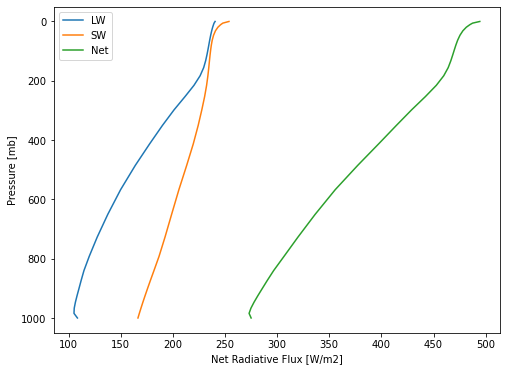

In [65]:
plt.rcParams["figure.figsize"] = (8,6)

plt.plot(radmodel.LW_flux_net, radmodel.lev_bounds, label='LW')
plt.plot(radmodel.SW_flux_net, radmodel.lev_bounds, label='SW')
plt.plot(radmodel.LW_flux_net+radmodel.SW_flux_net, radmodel.lev_bounds, label='Net')
plt.gca().invert_yaxis()
plt.xlabel('Net Radiative Flux [W/m2]')
plt.ylabel('Pressure [mb]')
plt.legend()